In [2]:
# Default view settings
import matplotlib

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:98% !important; }</style>'))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Prediction of the SOXX stock price through Time Series
On this project we'll try to predict accurately the stock price of the iShares Semiconductor ETF `SOXX`. `SOXX` is an Exchange Trading Fund (ETF) that seeks to track the investment results of an index composed of U.S.-listed equities in the semiconductor sector (design, manufature, and distribute semiconductors). The relevance of this study relies on the actual (Nov 2021) global shortage of semiconductor chips.

We will use de marked dat downloader called `yfinance` a Python library tha pulls current and historical stock market price data from Yahoo Finance.

In [3]:
#pip install yfinance
#pip install cufflinks

In [4]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns 
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt


In [5]:
ticker = 'SOXX'

# stock_data = yf.download('SOXX', period = 'ytd', progress=False)
stock_data = yf.download(ticker, 
                start='2015-01-01', 
                end='2021-11-20',
                progress=False)

In [6]:
print(f'Downloaded {stock_data.shape[0]} rows of data.')

stock_data.head()

Downloaded 1735 rows of data.


Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2015-01-02  93.300003  93.830002  91.940002  92.809998  85.727570  221000
2015-01-05  92.419998  92.589996  91.029999  91.059998  84.111122  206500
2015-01-06  91.120003  91.209999  88.769997  89.029999  82.236023  374600
2015-01-07  89.540001  90.309998  89.010002  89.910004  83.048882  240400
2015-01-08  90.820000  92.730003  90.820000  92.580002  85.515129  211000

### Convert Prices -> returns
**Adjusted close price**: Reflects the stock's value after accounting for any corporate actions. Differs from the *close price* which is just the cash value of the last transacted price the market closes.

We'll focus only on the adjusted close prices and we'll convert them to simple and log returns.

In [7]:
df = stock_data.loc[:, ['Adj Close']]  # Keep only on the adjusted close prices
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

df['simple_rtn'] = df.adj_close.pct_change()               # Convert to simple return
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1)) # Convert to log return
df.dropna(how = 'any', inplace = True)
df.head()

adj_close  simple_rtn   log_rtn
Date                                       
2015-01-05  84.111122   -0.018856 -0.019036
2015-01-06  82.236023   -0.022293 -0.022545
2015-01-07  83.048882    0.009884  0.009836
2015-01-08  85.515129    0.029696  0.029264
2015-01-09  85.561317    0.000540  0.000540

### Ploting 

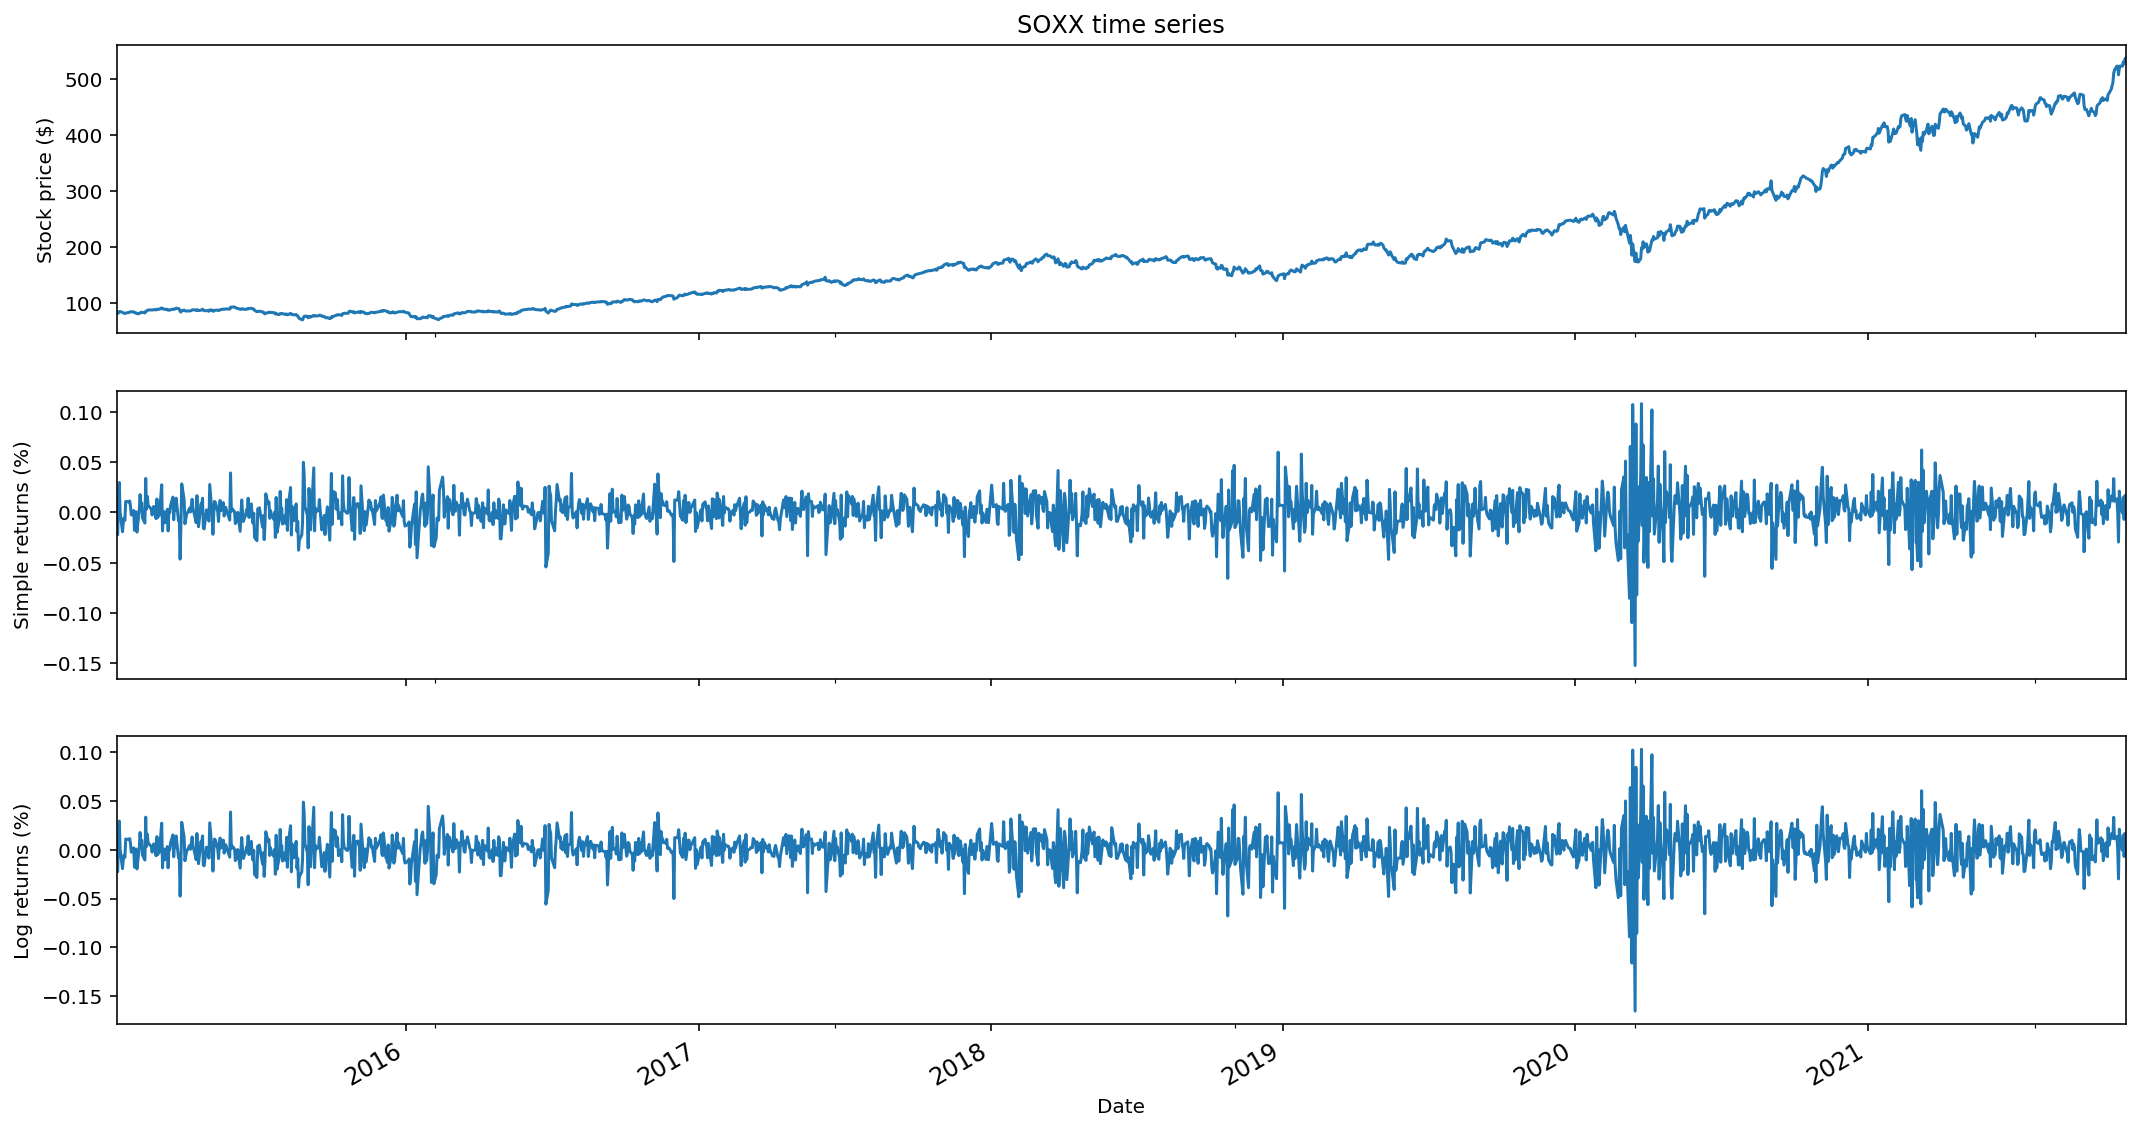

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10), sharex=True)

# add prices
df.adj_close.plot(ax=ax[0])
ax[0].set(title = ticker+' time series',
         ylabel = 'Stock price ($)')

# add simple returns 
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

# add log returns 
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', 
         ylabel = 'Log returns (%)')
ax[2].tick_params(axis='x',
                 which='major',
                 labelsize=12)
plt.show()

In [9]:
#Lets try with another library to visualize data -- plotly+cufflinks

import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
#Enabling the offline mode for interactive plotting locally 
#iplot is an interactive plot

# set up settings (run it once) to work on offline plots
cf.set_config_file(world_readable=True, theme='pearl',  offline=True)

# initialize notebook display
init_notebook_mode()

In [10]:
#create plot
#cf.set_config_file(world_readable=True, theme='pearl',offline=True)
df.iplot(subplots=True, shape=(3,1), shared_xaxes=True, title=ticker+' time series')

### Cleaning outliers

Rolling mean and standard deviation must be calculated

Rolling mean: unweighted mean of the last n values, usefull to detect patterns, smoothing short term fluctuations

Standard deviation: square root of the variace, measure of the variance of data. In this case it will tell us how reliable is a data


In [11]:
#calculate rolling and satandard deviation
df_rolling = df[['simple_rtn']].rolling(window=21) \
                               .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

#join rolling metrics to original data
df_outliers = df.join(df_rolling)

In [12]:
df_outliers.head()

adj_close  simple_rtn   log_rtn  mean  std
Date                                                  
2015-01-05  84.111122   -0.018856 -0.019036   NaN  NaN
2015-01-06  82.236023   -0.022293 -0.022545   NaN  NaN
2015-01-07  83.048882    0.009884  0.009836   NaN  NaN
2015-01-08  85.515129    0.029696  0.029264   NaN  NaN
2015-01-09  85.561317    0.000540  0.000540   NaN  NaN

In [13]:
def indentify_outliers(row, n_sigmas=3):
        '''
        Function for identifying the outliers outside a 3-sigma range. 
        The row must contain the following columns/indices: simple_rtn, mean, std.
        
        Parameters
        ----------
        row : pd.Series
        A row of a pd.DataFrame, over which the function can be applied.
        n_sigmas : int
        The number of standard deviations above/below the mean - used for detecting outliers
        
        Returns
        -------
        0/1 : int
        An integer with 1 indicating an outlier and 0 otherwise.
        '''''
        x = row['simple_rtn']
        mu = row['mean']
        sigma = row['std']
        
        if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
            return 1
        else:
            return 0 

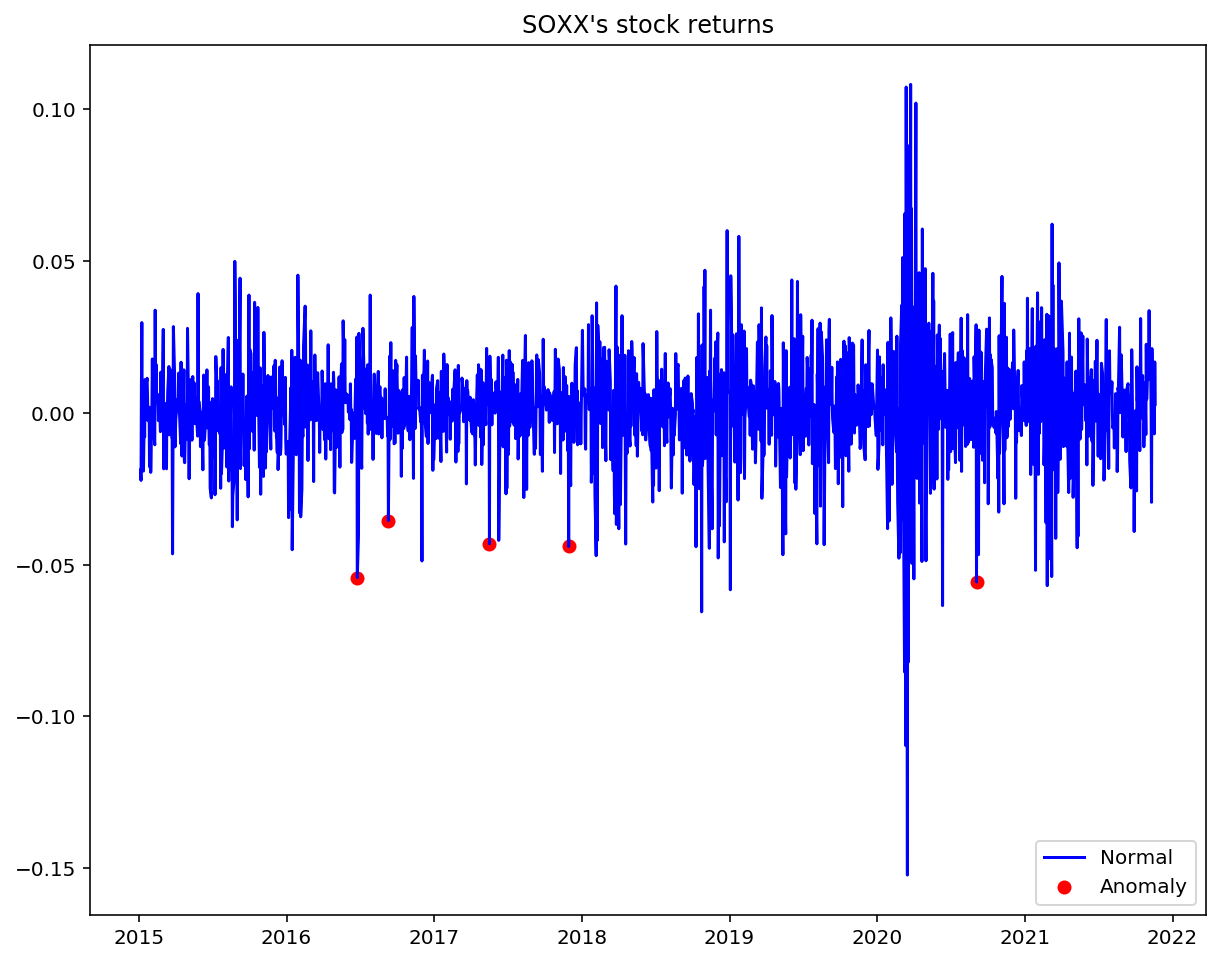

In [14]:
#identify
df_outliers['outlier'] = df_outliers.apply(indentify_outliers, axis=1)

#extract values
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]

#plot results
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df_outliers.index, df_outliers.simple_rtn, 
       color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
          color='red', label='Anomaly')
ax.set_title(ticker+"'s stock returns")
ax.legend(loc='lower right')

# plt.tight_layout()
plt.show()

## Stylized facts of asset returns

Is an event-based approach in which one attempts to ‘explain’ or rationalize a given market movement by relating it to an economic or political event or announcement. Such properties, common across a wide range of instruments, markets and time periods are called *stylized empirical facts* [1].

Stylized facts are very important to account for when we’re building financial models. They are statistical effects which are found in all asset return series [2].

We will study 5 stylized facts:

1. Distribution of returns – Is it non-Gaussian?
2. Are Volatility clusters formed in returns chart?
3. Is autocorrelation absent in returns
4. Decreasing autocorrelation trend in squared/absolute returns
5. Leverage effect
 
*********************************************************** 
[1] Cont, R. (2001). Empirical properties of asset returns: stylized facts and statistical issues. Quantitative finance, 1(2), 223.

[2] https://mlforanalytics.com/2020/04/19/financial-analytics-exploring-log-returns-distributions/

In [15]:
#ticker = 'SOXX'
df = yf.download(ticker, 
                start='1985-01-01', 
                end='2018-12-31',
                progress=False)

df = df[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
df = df[['adj_close', 'log_rtn']].dropna(how = 'any')

### 1. Non-Gaussian distribution of returns
Calculate the Normal probability density function (PDF) using the mean and standard deviation of the observed returns:

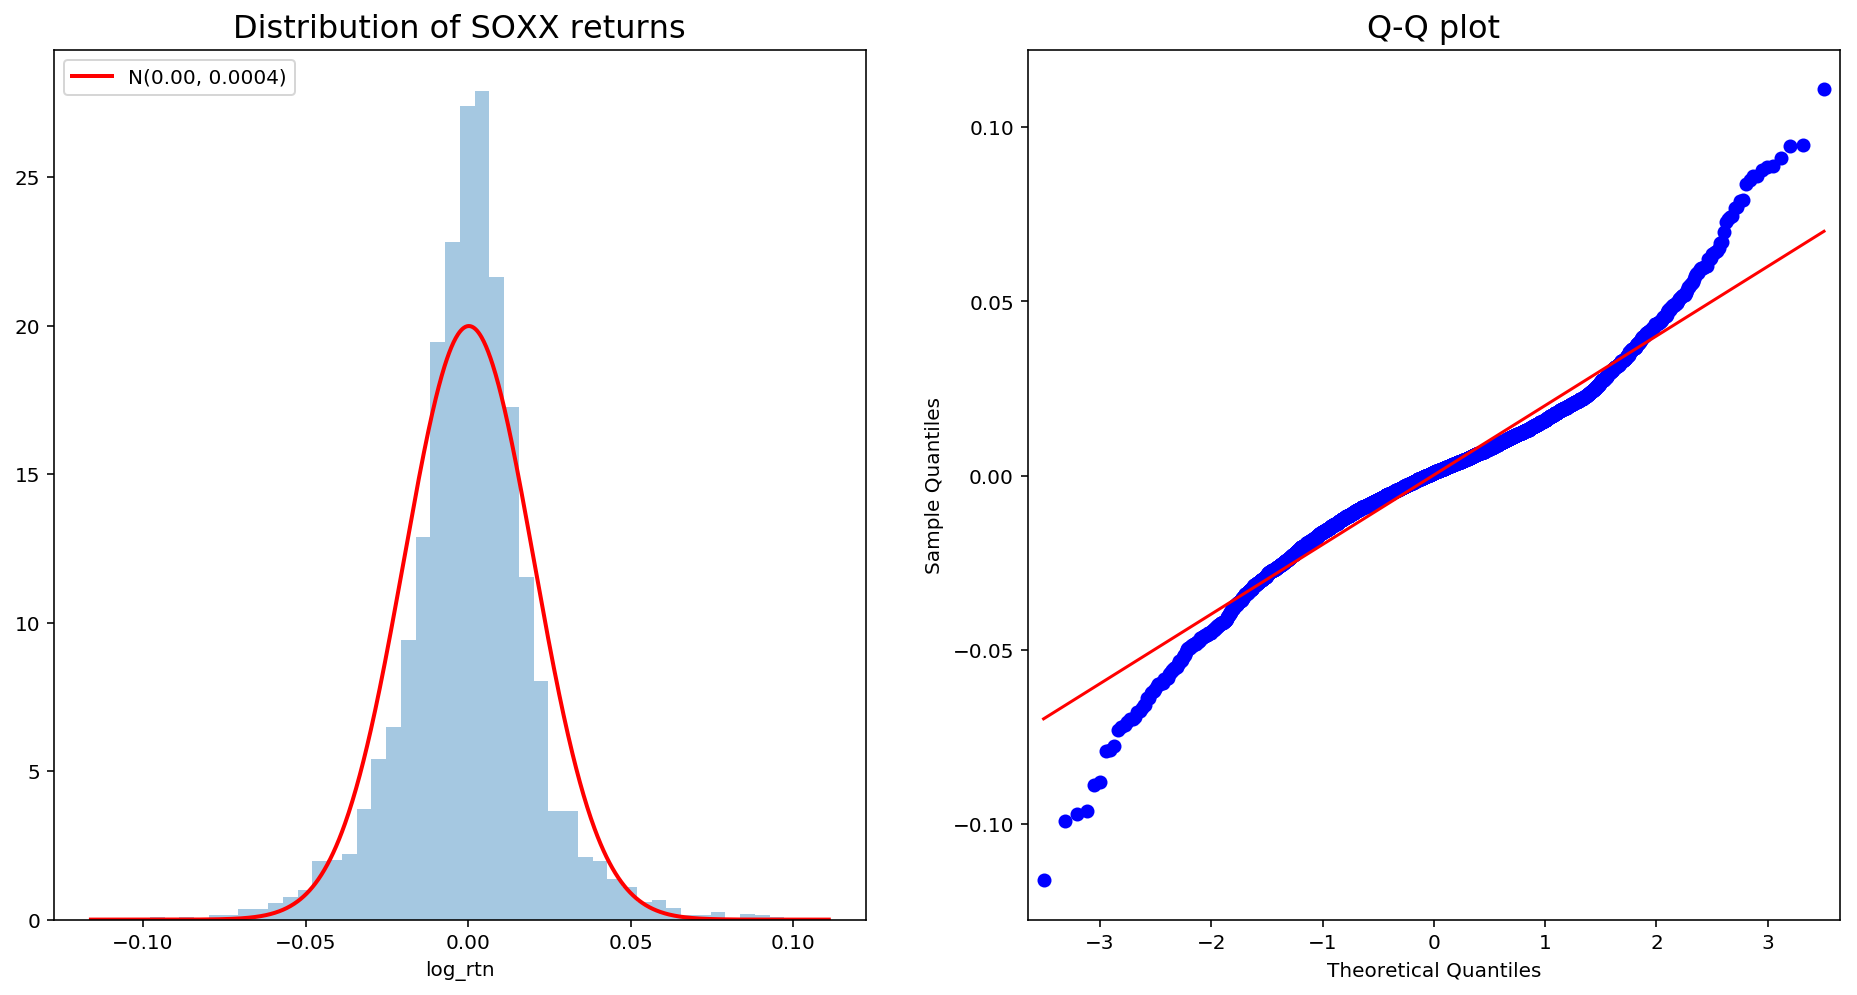

In [16]:
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma) #normal continuous random variable

#HISTOGRAM
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram with seaborn
# KDE plot smooths the observations with a Gaussian kernel,
#   producing a continuous density estimate
# [norm_hist] If True, the histogram height shows a density rather than a count.
#   This is implied if a KDE or fitted density is plotted.

sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])  
ax[0].set_title('Distribution of '+ ticker + ' returns', fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, 'r', lw=2,
          label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');


# Q-Q PLOT 
# achieved with statsmodels.api
# this shows us how ell a distribution adjust to our data
# in this case a normal distribution by default
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1]) #"s" standardized line
ax[1].set_title('Q-Q plot', fontsize = 16)


plt.show()

The left-most tail has points which are more negative than or smaller than expected when we compare this with Gaussian distribution. Thus, the left most tail is heavier in comparison to that of Gaussian distribution. The right-most tail has points which are more positive than expected ones from Gaussian distribution.

In [17]:
# SUMMARY

#Jarque-Bera goodness of fit test
#The Jarque-Bera test tests whether the sample data has the 
#  skewness and kurtosis matching a normal distribution.
#  being 0 the value that denotes normal distribution


jb_test = scs.jarque_bera(df.log_rtn.values) 

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}')
#kurtosis measures outliers only; it measures nothing about the "peak".
#High values of κ arise in two circumstances:
#   where the probability mass is concentrated around the mean and the data-generating 
#      process produces occasional values far from the mean,
#   where the probability mass is concentrated in the tails of the distribution.
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}')
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------- Descriptive Statistics ----------
Range of dates: 2001-07-16 - 2018-12-28
Number of observations: 4392
Mean: 0.0002
Median: 0.0009
Min: -0.1160
Max: 0.1109
Standard Deviation: 0.0200
Skewness: -0.0256
Kurtosis: 2.9032
Jarque-Bera statistic: 1537.96 with p-value: 0.00


We reject the null hypothesis that distribution is normal

### 2. Volatility Clustering property

As noted by Mandelbrot (1963), "Large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes."

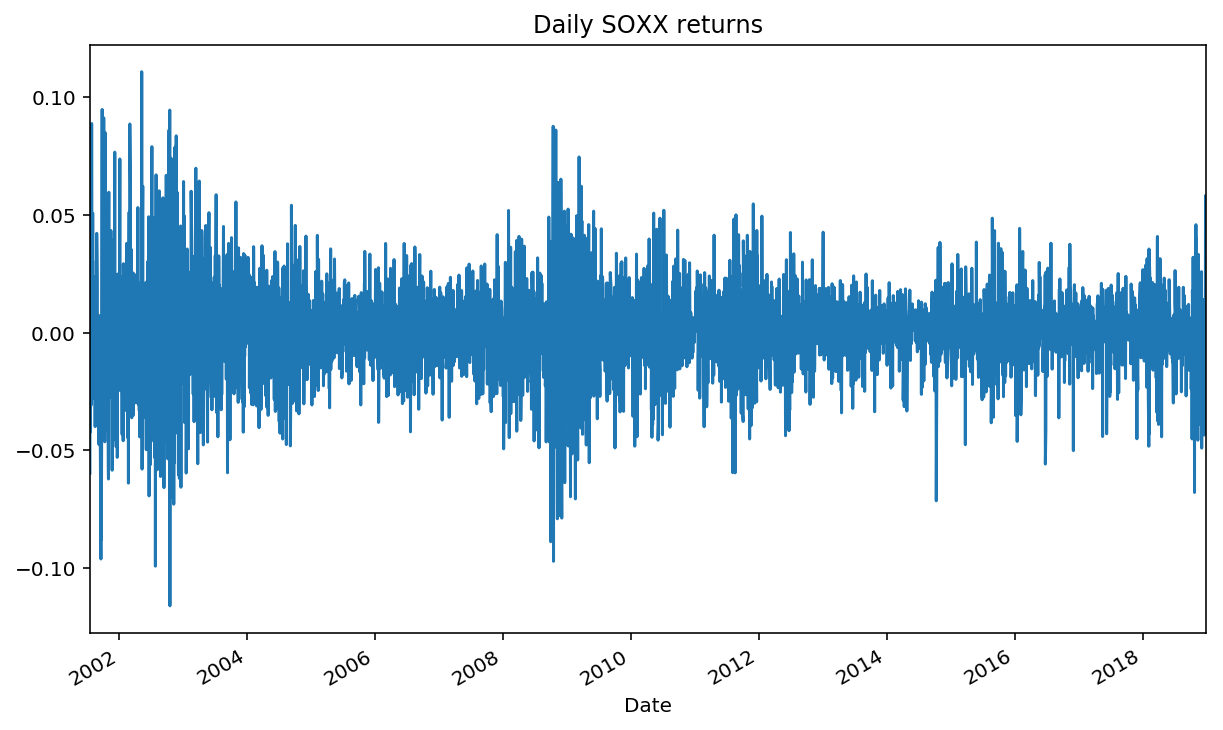

In [18]:
df.log_rtn.plot(title='Daily '+ticker+' returns', figsize=(10, 6))
plt.show()

### 3. Absence of autocorrelation in log returns

The steep drop of the autocorrelation function from lag=0 to lag=1 in the utocorrelogram of the time series indicates that the time constant of this series is very small

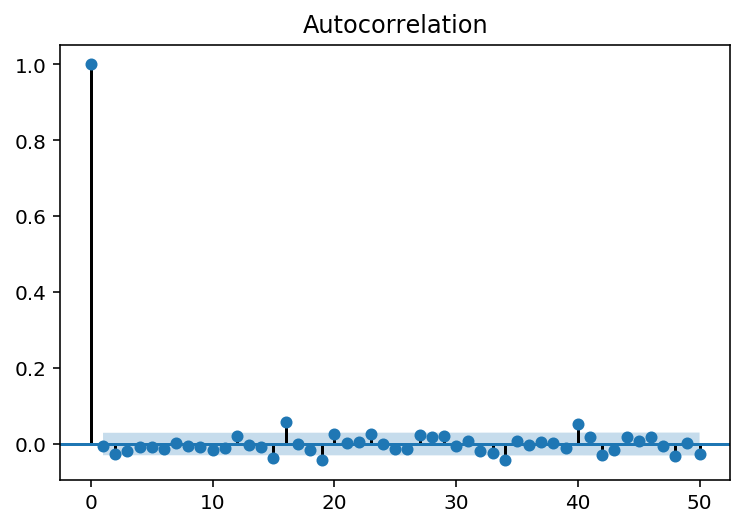

In [26]:
#statsmodels.tsa.api
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05
#confidence level by default at 95%
#iff a point is outside the confidence level, 
#you may say with 95% probability, it has a certain impact on values

#EXAMPLE 
#The second point is around 0.9 which means that following point 
#(directly next one) is described in 90% by the previous value.

acf = smt.graphics.plot_acf(df.log_rtn, 
                            lags=N_LAGS, 
                            alpha=SIGNIFICANCE_LEVEL)

plt.show()

Most of the data lies inside the confidence level, therefore, this data is not relevant enough to carry any meaningful information.

### 4. Small and decreasing autocorrelation in squared/absolute returns

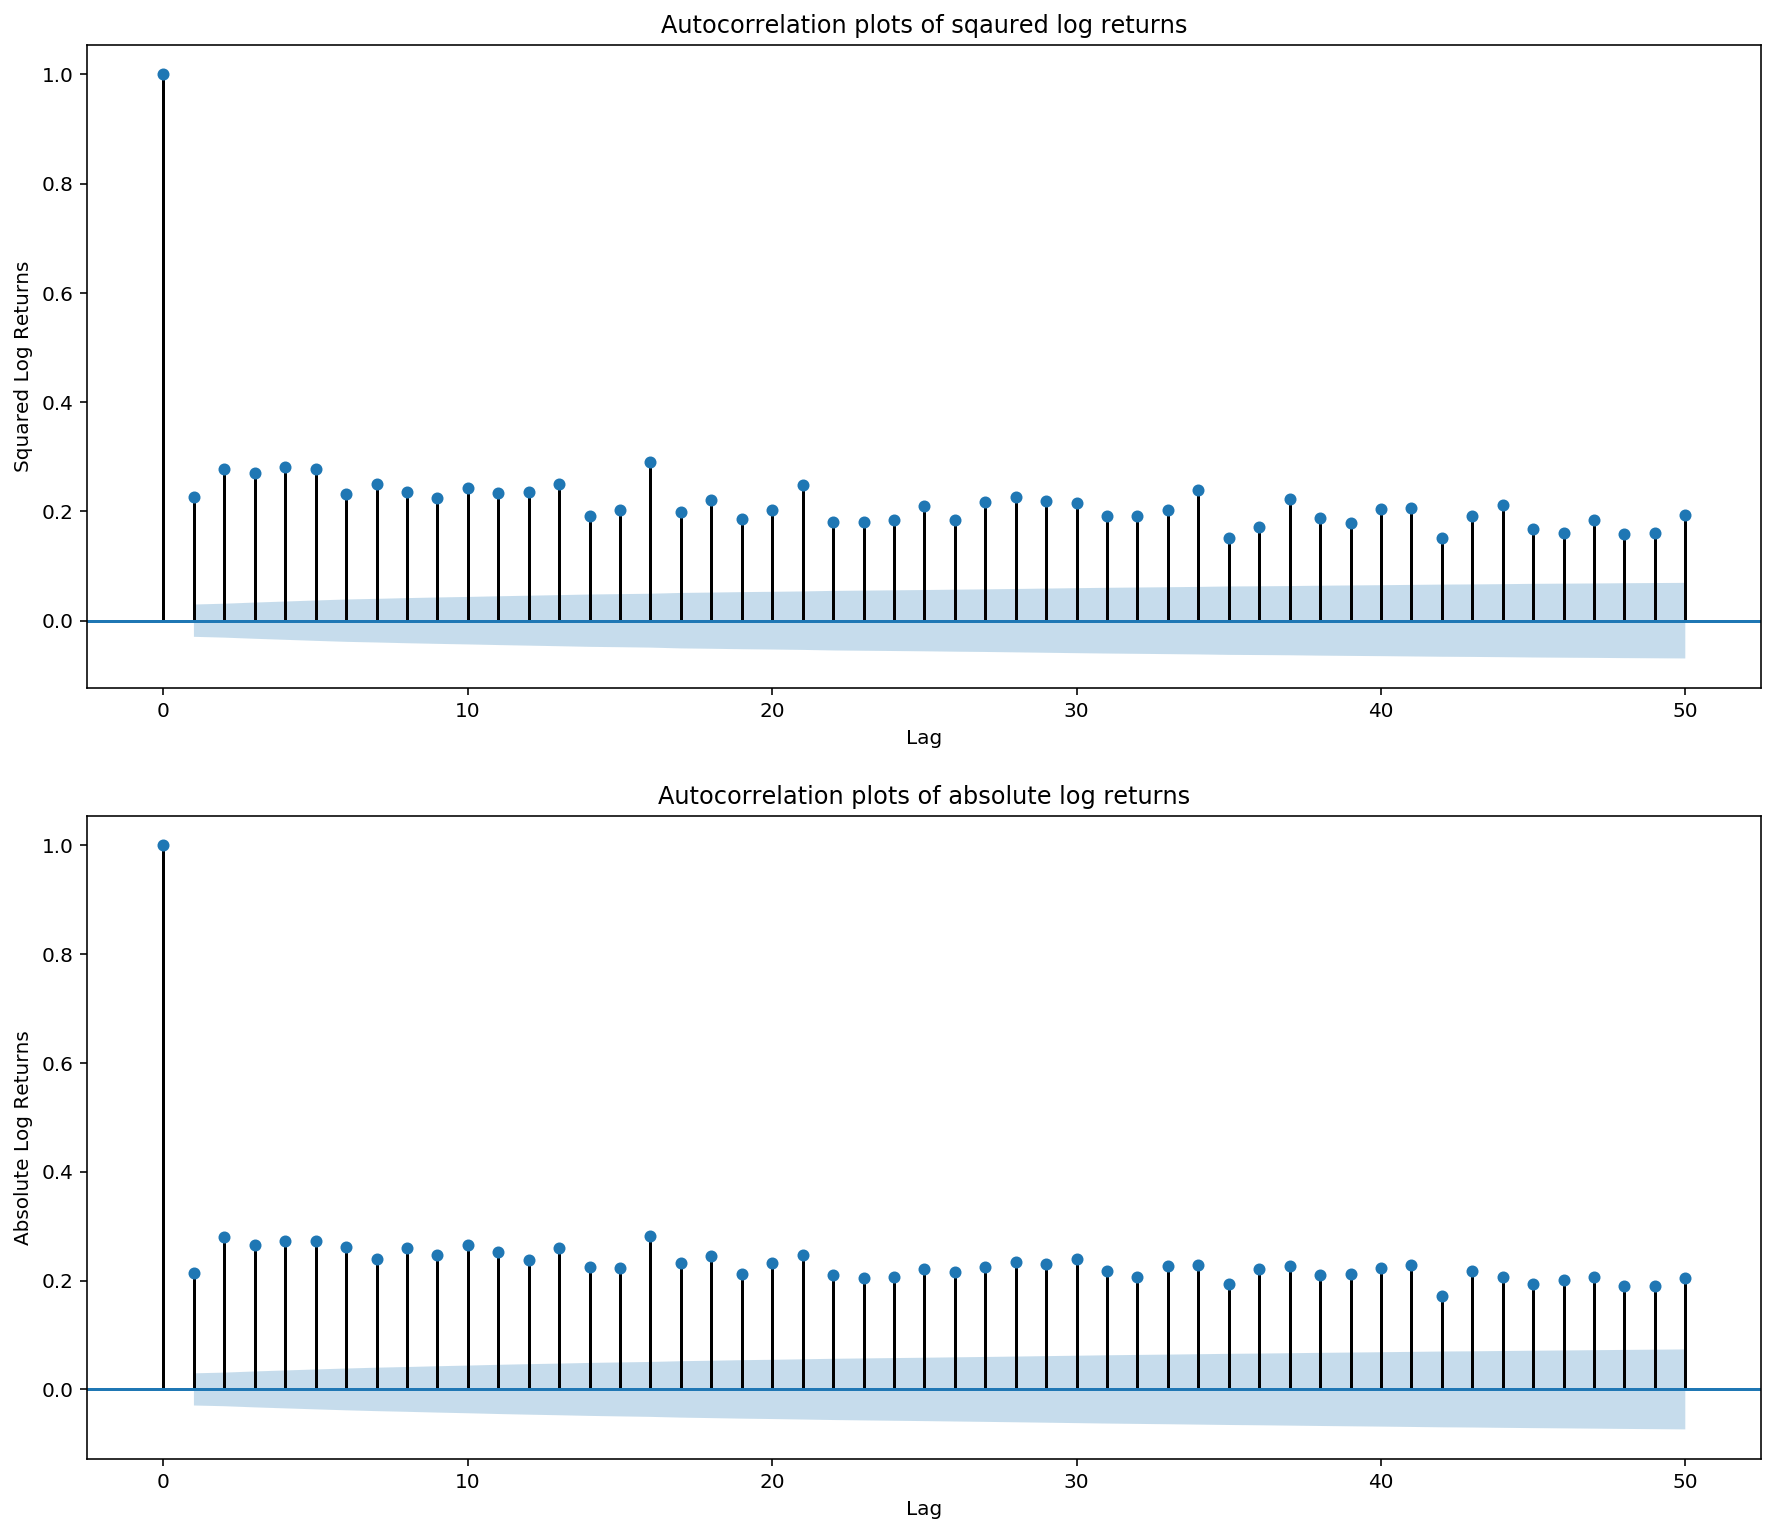

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(15, 13))

smt.graphics.plot_acf(df.log_rtn ** 2, lags=N_LAGS, 
                     alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelation plots of sqaured log returns', ylabel='Squared Log Returns', xlabel='Lag')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, 
                     alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(title='Autocorrelation plots of absolute log returns', ylabel='Absolute Log Returns',
         xlabel='Lag')

plt.show()

There is auto-correlation for squared and absolute log returns slowly decreasing

### 5. Leverage Effect using Python

*"Most measures of volatility of an asset are negatively correlated with the returns of that asset."* Cont (2001).

Leverage effect refers to negative correlation between asset’s returns and the changes in its volatility. Thus, whenever we see rise in returns, there will be a decrease in volatility.

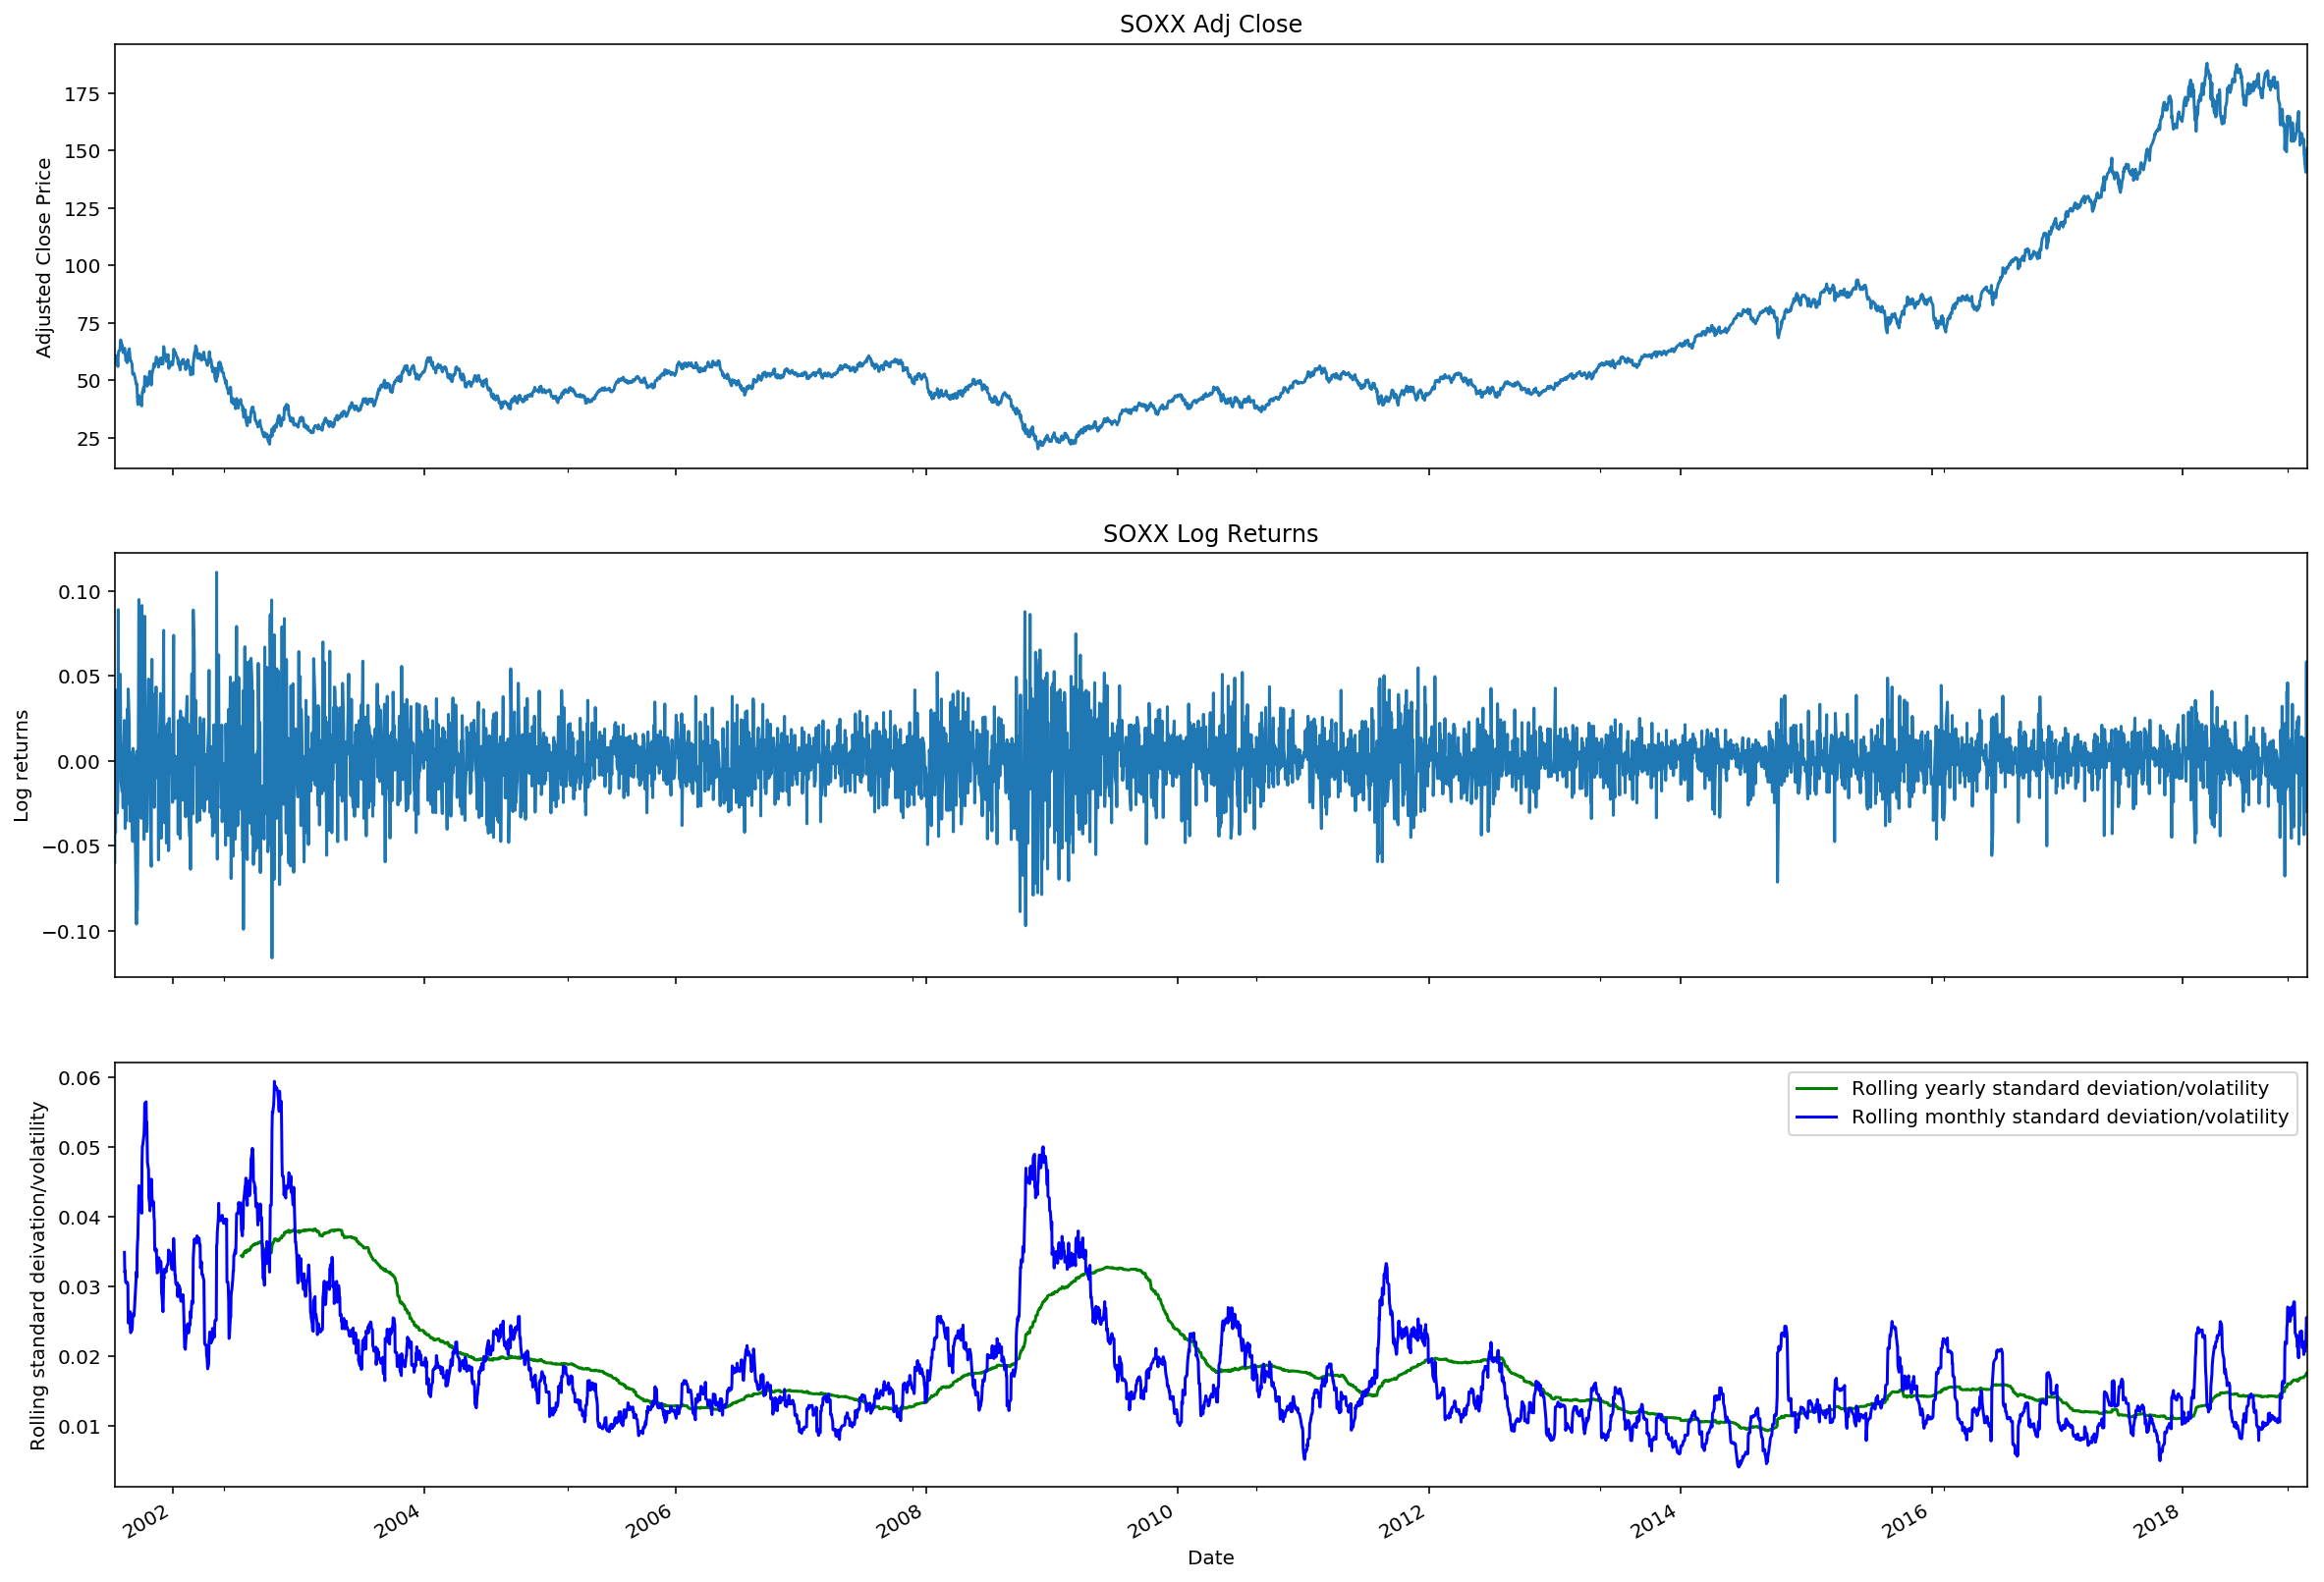

In [32]:
df['21_day_mstd'] = df[['log_rtn']].rolling(window=21).std() #Monthly window
df['252_day_mstd'] = df[['log_rtn']].rolling(window=252).std() #Yeary window

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(20, 15), sharex=True) 

# Subplot 1 - Daily Adj Close trend
df['adj_close'].plot(ax=ax[0])
ax[0].set(title=ticker+' Adj Close', ylabel='Adjusted Close Price')

# Subplot 2 - Daily log returns
df['log_rtn'].plot(ax=ax[1])
ax[1].set(title=ticker+' Log Returns', ylabel='Log returns')

# Subplot 3 - 21 days and 252 days windows to calculate rolling standard deviations
df['252_day_mstd'].plot(ax=ax[2], color='g', label='Rolling yearly standard deviation/volatility')
df['21_day_mstd'].plot(ax=ax[2], color='b', label='Rolling monthly standard deviation/volatility')
ax[2].set(ylabel='Rolling standard deivation/volatility', xlabel='Date')
ax[2].legend()


# Technical Analysis

# To be continued ...